# layers

In [ ]:
class BasicConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, bias=True, norm=False, relu=True, transpose=False):
        super(BasicConv, self).__init__()
        if bias and norm:
            bias = False

        padding = kernel_size // 2
        layers = list()
        if transpose:
            padding = kernel_size // 2 -1
            layers.append(nn.ConvTranspose2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        else:
            layers.append(
                nn.Conv2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        if norm:
            layers.append(nn.BatchNorm2d(out_channel))
        if relu:
            layers.append(nn.ReLU(inplace=True))
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ResBlock, self).__init__()
        self.main = nn.Sequential(
            BasicConv(in_channel, out_channel, kernel_size=3, stride=1, relu=True),
            BasicConv(out_channel, out_channel, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.main(x) + x

# model

## EBlock

In [ ]:
class EBlock(nn.Module):
    def __init__(self, out_channel, num_res=8):
        super(EBlock, self).__init__()

        layers = [ResBlock(out_channel, out_channel) for _ in range(num_res)]

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

MIMO-UNet++: num_res=20

## DBlock

In [ ]:
class DBlock(nn.Module):
    def __init__(self, channel, num_res=8):
        super(DBlock, self).__init__()

        layers = [ResBlock(channel, channel) for _ in range(num_res)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

## AFF（非对称特征融合）

<div align=center>
<img src=./img/AFF.png />
</div>

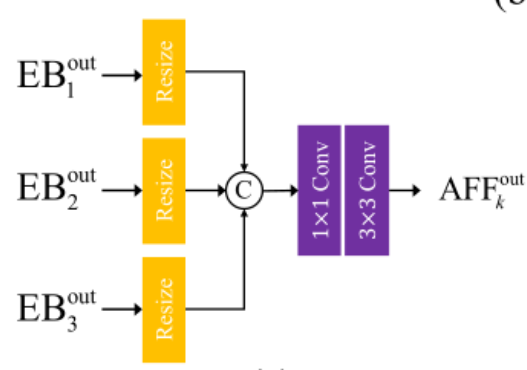

In [ ]:
class AFF(nn.Module):
    # in_channel=base*7 
    # out_channel=base*1
    def __init__(self, in_channel, out_channel):
        super(AFF, self).__init__()
        self.conv = nn.Sequential(
            BasicConv(in_channel, out_channel, kernel_size=1, stride=1, relu=True),
            BasicConv(out_channel, out_channel, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x1, x2, x4):
        x = torch.cat([x1, x2, x4], dim=1)
        return self.conv(x)

参考文献:

[Parallel Feature Pyramid Network for Object Detection](https://openaccess.thecvf.com/content_ECCV_2018/papers/Seung-Wook_Kim_Parallel_Feature_Pyramid_ECCV_2018_paper.pdf) ECCV 2018

AFF和该论文中的MSCA结构一模一样


## SCM 

<div align=center>
<img src=./img/SCM.png />
</div>

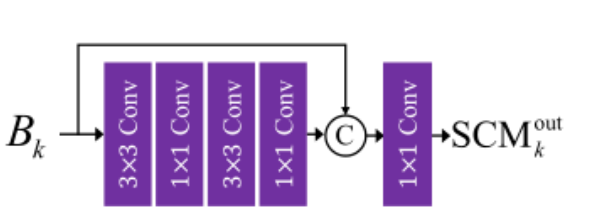

In [ ]:
class SCM(nn.Module):
    def __init__(self, out_plane):
        super(SCM, self).__init__()
        self.main = nn.Sequential(
            BasicConv(3, out_plane//4, kernel_size=3, stride=1, relu=True),
            BasicConv(out_plane // 4, out_plane // 2, kernel_size=1, stride=1, relu=True),
            BasicConv(out_plane // 2, out_plane // 2, kernel_size=3, stride=1, relu=True),
            BasicConv(out_plane // 2, out_plane-3, kernel_size=1, stride=1, relu=True)
        )

        self.conv = BasicConv(out_plane, out_plane, kernel_size=1, stride=1, relu=False)

    def forward(self, x):
        x = torch.cat([x, self.main(x)], dim=1)
        return self.conv(x)

## FAM 

<div align=center> 
<img src=./img/FAM.png />
</div>

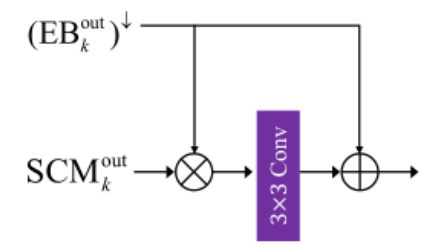

In [ ]:
class FAM(nn.Module):
    def __init__(self, channel):
        super(FAM, self).__init__()
        self.merge = BasicConv(channel, channel, kernel_size=3, stride=1, relu=False)

    def forward(self, x1, x2):
        x = x1 * x2
        out = x1 + self.merge(x)
        return out

# MIMOUNet 

<div align=center>
<img src=./img/Architecture.jpg />
</div>

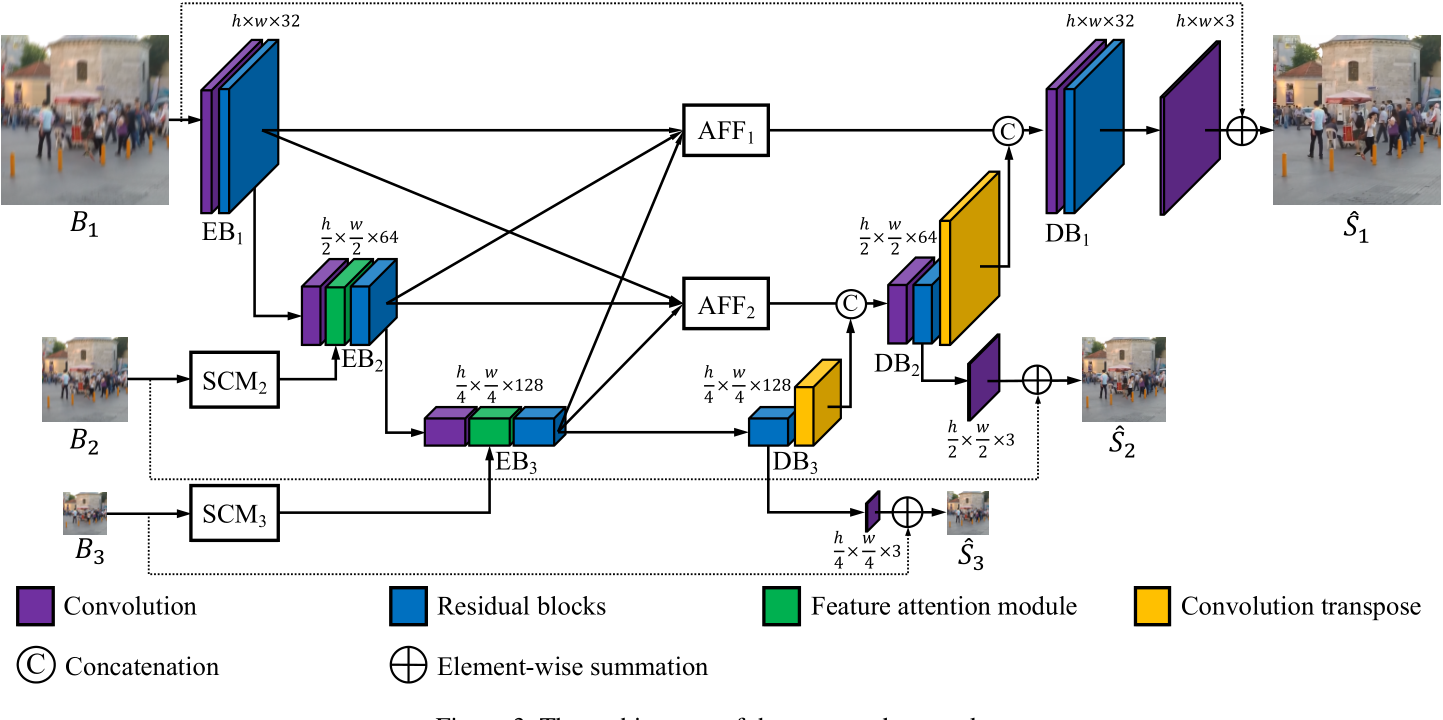

In [ ]:
class MIMOUNet(nn.Module):
    def __init__(self, num_res=8):
        super(MIMOUNet, self).__init__()

        base_channel = 32

        self.Encoder = nn.ModuleList([
            EBlock(base_channel, num_res),
            EBlock(base_channel*2, num_res),
            EBlock(base_channel*4, num_res),
        ])

        self.feat_extract = nn.ModuleList([
            BasicConv(3, base_channel, kernel_size=3, relu=True, stride=1),
            BasicConv(base_channel, base_channel*2, kernel_size=3, relu=True, stride=2),
            BasicConv(base_channel*2, base_channel*4, kernel_size=3, relu=True, stride=2),
            BasicConv(base_channel*4, base_channel*2, kernel_size=4, relu=True, stride=2, transpose=True),
            BasicConv(base_channel*2, base_channel, kernel_size=4, relu=True, stride=2, transpose=True),
            BasicConv(base_channel, 3, kernel_size=3, relu=False, stride=1)
        ])

        self.Decoder = nn.ModuleList([
            DBlock(base_channel * 4, num_res),
            DBlock(base_channel * 2, num_res),
            DBlock(base_channel, num_res)
        ])

        self.Convs = nn.ModuleList([
            BasicConv(base_channel * 4, base_channel * 2, kernel_size=1, relu=True, stride=1),
            BasicConv(base_channel * 2, base_channel, kernel_size=1, relu=True, stride=1),
        ])

        self.ConvsOut = nn.ModuleList(
            [
                BasicConv(base_channel * 4, 3, kernel_size=3, relu=False, stride=1),
                BasicConv(base_channel * 2, 3, kernel_size=3, relu=False, stride=1),
            ]
        )

        self.AFFs = nn.ModuleList([
            AFF(base_channel * 7, base_channel*1),
            AFF(base_channel * 7, base_channel*2)
        ])

        self.FAM1 = FAM(base_channel * 4)
        self.SCM1 = SCM(base_channel * 4)
        self.FAM2 = FAM(base_channel * 2)
        self.SCM2 = SCM(base_channel * 2)

    def forward(self, x):
        x_2 = F.interpolate(x, scale_factor=0.5)
        x_4 = F.interpolate(x_2, scale_factor=0.5)
        z2 = self.SCM2(x_2)
        z4 = self.SCM1(x_4)

        outputs = list()

        x_ = self.feat_extract[0](x)
        res1 = self.Encoder[0](x_)

        z = self.feat_extract[1](res1)
        z = self.FAM2(z, z2)
        res2 = self.Encoder[1](z)

        z = self.feat_extract[2](res2)
        z = self.FAM1(z, z4)
        z = self.Encoder[2](z)

        z12 = F.interpolate(res1, scale_factor=0.5)
        z21 = F.interpolate(res2, scale_factor=2)
        z42 = F.interpolate(z, scale_factor=2)
        z41 = F.interpolate(z42, scale_factor=2)

        res2 = self.AFFs[1](z12, res2, z42)
        res1 = self.AFFs[0](res1, z21, z41)

        z = self.Decoder[0](z)
        z_ = self.ConvsOut[0](z)
        z = self.feat_extract[3](z)
        outputs.append(z_+x_4)

        z = torch.cat([z, res2], dim=1)
        z = self.Convs[0](z)
        z = self.Decoder[1](z)
        z_ = self.ConvsOut[1](z)
        z = self.feat_extract[4](z)
        outputs.append(z_+x_2)

        z = torch.cat([z, res1], dim=1)
        z = self.Convs[1](z)
        z = self.Decoder[2](z)
        z = self.feat_extract[5](z)
        outputs.append(z+x)

        return outputs


# Train

## setup 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=args.learning_rate,
                            weight_decay=args.weight_decay)
dataloader = train_dataloader(args.data_dir, args.batch_size, args.num_worker)

## load_resume 

In [ ]:
if args.resume:
        state = torch.load(args.resume)
        epoch = state['epoch']
        optimizer.load_state_dict(state['optimizer'])
        scheduler.load_state_dict(state['scheduler'])
        model.load_state_dict(state['model'])
        print('Resume from %d'%epoch)
        epoch += 1

## loss 

In [ ]:
pred_img = model(input_img)

label_img2 = F.interpolate(label_img, scale_factor=0.5, mode='bilinear')
label_img4 = F.interpolate(label_img, scale_factor=0.25, mode='bilinear')

l1 = criterion(pred_img[0], label_img4)
l2 = criterion(pred_img[1], label_img2)
l3 = criterion(pred_img[2], label_img)

loss_content = l1+l2+l3

label_fft1 = torch.rfft(label_img4, signal_ndim=2, normalized=False, onesided=False)
pred_fft1 = torch.rfft(pred_img[0], signal_ndim=2, normalized=False, onesided=False)
label_fft2 = torch.rfft(label_img2, signal_ndim=2, normalized=False, onesided=False)
pred_fft2 = torch.rfft(pred_img[1], signal_ndim=2, normalized=False, onesided=False)
label_fft3 = torch.rfft(label_img, signal_ndim=2, normalized=False, onesided=False)
pred_fft3 = torch.rfft(pred_img[2], signal_ndim=2, normalized=False, onesided=False)

f1 = criterion(pred_fft1, label_fft1)
f2 = criterion(pred_fft2, label_fft2)
f3 = criterion(pred_fft3, label_fft3)
loss_fft = f1+f2+f3

loss = loss_content + 0.1 * loss_fft

## validation 

In [ ]:
if epoch_idx % args.save_freq == 0:
    save_name = os.path.join(args.model_save_dir, 'model_%d.pkl' % epoch_idx)
    torch.save({'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'epoch': epoch_idx}, save_name)
    print("EPOCH: %02d\nElapsed time: %4.2f Epoch Pixel Loss: %7.4f Epoch FFT Loss: %7.4f" % (
            epoch_idx, epoch_timer.toc(), epoch_pixel_adder.average(), epoch_fft_adder.average()))
    epoch_fft_adder.reset()
    epoch_pixel_adder.reset()
    scheduler.step()
    if epoch_idx % args.valid_freq == 0:
        val_gopro = _valid(model, args, epoch_idx)
        print('%03d epoch \n Average GOPRO PSNR %.2f dB' % (epoch_idx, val_gopro))
        writer.add_scalar('PSNR_GOPRO', val_gopro, epoch_idx)
        if val_gopro >= best_psnr:
            torch.save({'model': model.state_dict()}, os.path.join(args.model_save_dir, 'Best.pkl'))